In [1]:
import torch
from torchvision import datasets, transforms
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import kagglehub

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("pankrzysiu/cifar10-python")
print("Path to dataset files:", path)

Path to dataset files: C:\Users\Shubh Sareen\.cache\kagglehub\datasets\pankrzysiu\cifar10-python\versions\1


### Not separating the dataset because it is already separated

In [3]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])
batch_size = 64
train_dataset = datasets.CIFAR10(root=path, train=True, download=False, transform=transform)
test_dataset = datasets.CIFAR10(root=path, train=False, download=False, transform=transform)
train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False)


In [4]:
class TransferLearning(nn.Module):
    def __init__(self, classes = 10):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(16, 3, kernel_size=3, padding=1)
        self.resnet = models.resnet50(pretrained=True)
        self.resnet.fc = nn.Identity()
        self.fc1 = nn.Linear(2048, 256)
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(256, 32)
        self.fc3 = nn.Linear(32, classes)
        self.relu = nn.ReLU()
    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.resnet(x)
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TransferLearning().to(device)

C:\Users\Shubh Sareen\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Shubh Sareen\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)

In [6]:
def train(dataloader, model, loss_fn, optimizer):
  size = len(dataloader.dataset)
  model.train()
  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)

    pred = model(X)
    loss = loss_fn(pred, y)

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    if batch % 100 == 0:
            loss, current = loss.item(), (batch+1)*len(X)
            print(f"Loss: {loss:>7f} [{current:>5d} / {size:>5d}]")

In [7]:
def test(dataloader, model, loss_fn):
  size = len(dataloader.dataset)
  num_batches = len(dataloader)
  model.eval()
  test_loss, correct = 0, 0
  with torch.no_grad():
    for X, y in dataloader:
      X, y = X.to(device), y.to(device)
      pred = model(X)
      test_loss += loss_fn(pred, y).item()
      correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg Loss: {test_loss:>8f} \n")

# Before Training

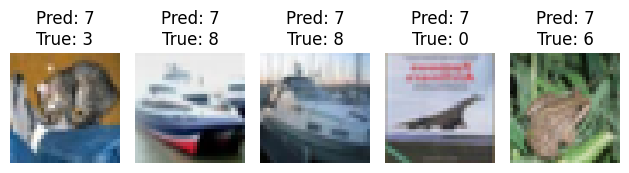

In [8]:
def viz_predictions(model, dataset, num_samples=5):
    fig, axes = plt.subplots(1, num_samples)
    model.eval()
    with torch.no_grad():
        for i in range(num_samples):
            img, label = dataset[i]
            X = img.unsqueeze(0).to(device)
            pred = model(X)
            predicted = pred.argmax(1)
            axes[i].imshow(img.permute(1, 2, 0))
            axes[i].set_title(f'Pred: {predicted.item()}\nTrue: {label}')
            axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Call visualization function
viz_predictions(model, test_dataset)

In [9]:
epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n--------------------")
    train(train_loader, model, loss_fn, optimizer)
    test(test_loader, model, loss_fn)
print("Done")

Epoch 1
--------------------
Loss: 2.301503 [   64 / 50000]
Loss: 2.248595 [ 6464 / 50000]
Loss: 2.193324 [12864 / 50000]
Loss: 2.149947 [19264 / 50000]
Loss: 1.975105 [25664 / 50000]
Loss: 2.060717 [32064 / 50000]
Loss: 1.745930 [38464 / 50000]
Loss: 1.795523 [44864 / 50000]
Test Error: 
 Accuracy: 42.3%, Avg Loss: 1.671980 

Epoch 2
--------------------
Loss: 1.824019 [   64 / 50000]
Loss: 1.886992 [ 6464 / 50000]
Loss: 1.469941 [12864 / 50000]
Loss: 1.609966 [19264 / 50000]
Loss: 1.383577 [25664 / 50000]
Loss: 1.421094 [32064 / 50000]
Loss: 1.475987 [38464 / 50000]
Loss: 1.328264 [44864 / 50000]
Test Error: 
 Accuracy: 56.0%, Avg Loss: 1.289206 

Epoch 3
--------------------
Loss: 1.165814 [   64 / 50000]
Loss: 1.281787 [ 6464 / 50000]
Loss: 1.331185 [12864 / 50000]
Loss: 1.145632 [19264 / 50000]
Loss: 1.286282 [25664 / 50000]
Loss: 1.077716 [32064 / 50000]
Loss: 1.058732 [38464 / 50000]
Loss: 1.429871 [44864 / 50000]
Test Error: 
 Accuracy: 61.5%, Avg Loss: 1.133098 

Epoch 4
-----

# After Training

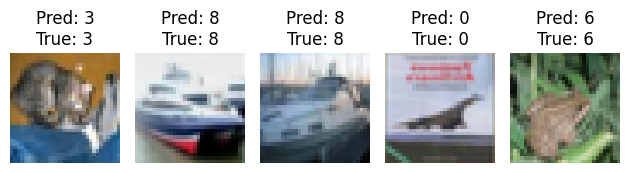

In [18]:
def viz_predictions(model, dataset, num_samples=5):
    fig, axes = plt.subplots(1, num_samples)
    model.eval()
    with torch.no_grad():
        for i in range(num_samples):
            img, label = dataset[i]
            X = img.unsqueeze(0).to(device)
            pred = model(X)
            predicted = pred.argmax(1)
            axes[i].imshow(img.permute(1, 2, 0))
            axes[i].set_title(f'Pred: {predicted.item()}\nTrue: {label}')
            axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Call visualization function
viz_predictions(model, test_dataset)